# 基于词向量的英汉翻译——“火炬上的深度学习"下第一次作业

在这个作业中，你需要半独立地完成一个英文到中文的单词翻译器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [1]:
# 加载必要的程序包
# PyTorch的程序包
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 数值运算和绘图的程序包
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


# 加载机器学习的软件包，主要为了词向量的二维可视化
from sklearn.decomposition import PCA

#加载Word2Vec的软件包
import gensim as gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import LineSentence

#加载正则表达式处理的包
import re

#在Notebook界面能够直接显示图形
%matplotlib inline

## 第一步：加载词向量

首先，让我们加载别人已经在大型语料库上训练好的词向量

In [2]:
# 加载中文词向量，下载地址为：链接：http://pan.baidu.com/s/1gePQAun 密码：kvtg
# 该中文词向量库是由尹相志提供，训练语料来源为：微博、人民日报、上海热线、汽车之家等，包含1366130个词向量
word_vectors = KeyedVectors.load_word2vec_format('vectors.bin', binary=True, unicode_errors='ignore')
len(word_vectors.vocab)

1366130

In [3]:
# 加载英文的词向量，下载地址为：http://nlp.stanford.edu/data/glove.6B.zip，解压后将glove.6B.100d.txt文件拷贝到与本notebook
# 文件一致的文件夹下面。
f = open('glove.6B.100d.txt', 'r')
i = 1

# 将英文的词向量都存入如下的字典中  该字典以每个word作为key，相应的词向量作为value，共40w个词
word_vectors_en = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        numbers = line.split()
        word = numbers[0]
        vectors = np.array([float(i) for i in numbers[1 : ]])
        word_vectors_en[word] = vectors
#        i += 1        #没有用到变量i
print(len(word_vectors_en))

400000


## 第二步：可视化同一组意思词在两种不同语言的词向量中的相互位置关系

In [6]:
# 中文的一二三四五列表
cn_list = {'一', '二', '三', '四', '五', '六', '七', '八', '九', '零'}
# 阿拉伯数字的12345列表
en_list = {'1', '2', '3', '4', '5', '6', '7', '8', '9', '0'}
# 英文数字的列表
en_list = {'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero'}

# 对应词向量都存入到列表中
cn_vectors = []  #中文的词向量列表
en_vectors = []  #英文的词向量列表
for w in cn_list:
    cn_vectors.append(word_vectors[w])
for w in en_list:
    en_vectors.append(word_vectors_en[w])

# 将这些词向量统一转化为矩阵
cn_vectors = np.array(cn_vectors)
en_vectors = np.array(en_vectors)
print(cn_vectors.size, en_vectors.size)   #中文词向量200dimensions, 英文词向量100d

2000 1000


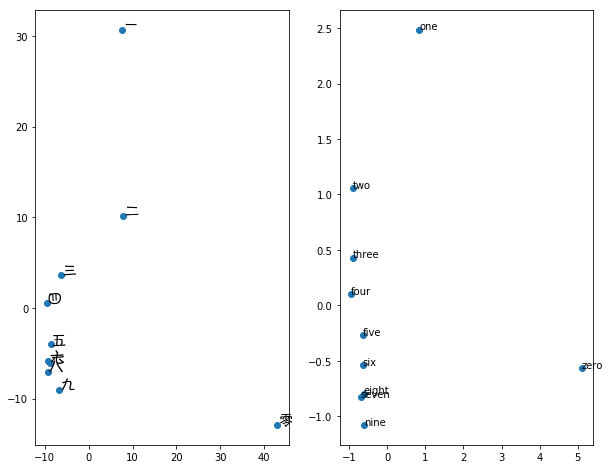

In [7]:
# 降维实现可视化
X_reduced = PCA(n_components=2).fit_transform(cn_vectors)
Y_reduced = PCA(n_components = 2).fit_transform(en_vectors)

# 绘制所有单词向量的二维空间投影
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 8))
ax1.plot(X_reduced[:, 0], X_reduced[:, 1], 'o')
ax2.plot(Y_reduced[:, 0], Y_reduced[:, 1], 'o')
zhfont1 = matplotlib.font_manager.FontProperties(fname='/usr/share/fonts/Chinese/方正蓝屏死机简体.ttf', size=16)
for i, w in enumerate(cn_list):
    ax1.text(X_reduced[i, 0], X_reduced[i, 1], w, fontproperties = zhfont1, alpha = 1)
for i, w in enumerate(en_list):
    ax2.text(Y_reduced[i, 0], Y_reduced[i, 1], w, alpha = 1)

### 结论：可以看出，中文的一、二、等数字彼此之间的关系与英文的数字彼此之间的关系很类似

## 第三步：训练一个神经网络，输入一个英文单词的词向量，输出一个中文的词向量，并翻译为中文

首先，读入一个已经建立好的词典（dictionary.txt）。本词典是老师调用百度翻译的API，自动将一篇英文小说中的词汇逐个翻译为中文而得来的

我们一个个地载入词典，并查找对应的中文词向量，如果找得到，则放入original_words中，做为正式的训练集

In [8]:
original_words = []
with open('dictionary.txt', 'r') as f:
    dataset = []
    for line in f:
        itm = line.split('\t')
        eng = itm[0]
        chn = itm[1].strip()
        if eng in word_vectors_en and chn in word_vectors:
            data = word_vectors_en[eng]
            target = word_vectors[chn]
            # 将中英文词对做成数据集
            dataset.append([data, target])
            original_words.append([eng, chn])
print(len(dataset)) # 共有4962个单词做为总的数据集合

4962


In [42]:
# 建立训练集、测试集和校验集
# 训练集用来训练神经网络，更改网络的参数；校验集用来判断网络模型是否过拟合：当校验集的损失数值超过训练集的时候，即为过拟合
# 测试集用来检验模型的好坏
indx = np.random.permutation(range(len(dataset)))   #打乱原来的顺序，但dataset和original_words仍然是对应的
dataset = [dataset[i] for i in indx]
original_words = [original_words[i] for i in indx]
train_size = 500
train_data = dataset[train_size:]
valid_data = dataset[train_size // 2 : train_size]
test_data = dataset[: train_size // 2]
test_words = original_words[: train_size // 2]


In [58]:
# 开始训练一个多层神经网络，将一个100维度的英文向量映射为200维度的中文词向量，隐含层节点为30

input_size = 100
output_size = 200
hidden_size = 80

# 新建一个神经网络，包含一个隐含层
model = nn.Sequential(nn.Linear(input_size, hidden_size),
                      nn.LeakyReLU(),
                      nn.Linear(hidden_size, output_size)
                     )

# 构造损失函数
criterion = torch.nn.MSELoss() 

# 构造优化器
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0002)

# 总的循环周期
num_epoch = 80


#开始训练500次，每次对所有的数据都做循环
results = []
for epoch in range(num_epoch):
    train_loss = []
    for data in train_data:
        # 读入数据
        x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
        y = Variable(torch.FloatTensor(data[1])).unsqueeze(0)
        # 模型预测
        output = model(x)
        
        # 反向传播算法训练
        optimizer.zero_grad()
        loss = criterion(output, y)
        train_loss.append(loss.data.numpy()[0])
        loss.backward()
        optimizer.step()
    # 在校验集上测试一下效果
    valid_loss = []
    for data in valid_data:
        x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
        y = Variable(torch.FloatTensor(data[1])).unsqueeze(0)
        output = model(x)
        loss = criterion(output, y)
        valid_loss.append(loss.data.numpy()[0])
    results.append([np.mean(train_loss), np.mean(valid_loss)])
    print('{}轮，训练Loss: {:.2f}, 校验Loss: {:.2f}'.format(epoch, np.mean(train_loss), np.mean(valid_loss)))


0轮，训练Loss: 8.32, 校验Loss: 7.64
1轮，训练Loss: 7.66, 校验Loss: 7.32
2轮，训练Loss: 7.39, 校验Loss: 7.17
3轮，训练Loss: 7.23, 校验Loss: 7.07
4轮，训练Loss: 7.12, 校验Loss: 7.01
5轮，训练Loss: 7.04, 校验Loss: 6.96
6轮，训练Loss: 6.98, 校验Loss: 6.93
7轮，训练Loss: 6.93, 校验Loss: 6.90
8轮，训练Loss: 6.89, 校验Loss: 6.88
9轮，训练Loss: 6.85, 校验Loss: 6.86
10轮，训练Loss: 6.82, 校验Loss: 6.84
11轮，训练Loss: 6.79, 校验Loss: 6.83
12轮，训练Loss: 6.77, 校验Loss: 6.82
13轮，训练Loss: 6.75, 校验Loss: 6.81
14轮，训练Loss: 6.73, 校验Loss: 6.80
15轮，训练Loss: 6.71, 校验Loss: 6.79
16轮，训练Loss: 6.69, 校验Loss: 6.79
17轮，训练Loss: 6.68, 校验Loss: 6.78
18轮，训练Loss: 6.66, 校验Loss: 6.78
19轮，训练Loss: 6.65, 校验Loss: 6.78
20轮，训练Loss: 6.64, 校验Loss: 6.77
21轮，训练Loss: 6.62, 校验Loss: 6.77
22轮，训练Loss: 6.61, 校验Loss: 6.77
23轮，训练Loss: 6.60, 校验Loss: 6.76
24轮，训练Loss: 6.59, 校验Loss: 6.76
25轮，训练Loss: 6.58, 校验Loss: 6.76
26轮，训练Loss: 6.57, 校验Loss: 6.76
27轮，训练Loss: 6.57, 校验Loss: 6.76
28轮，训练Loss: 6.56, 校验Loss: 6.76
29轮，训练Loss: 6.55, 校验Loss: 6.76
30轮，训练Loss: 6.54, 校验Loss: 6.76
31轮，训练Loss: 6.54, 校验Loss: 6.76
32轮，训练Loss: 6.53, 

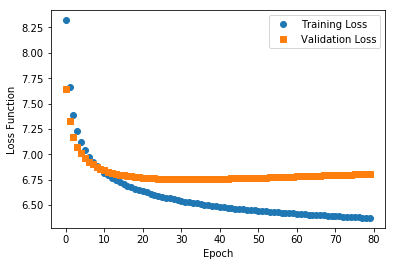

In [59]:
# 绘制图形
a = [i[0] for i in results]
b = [i[1] for i in results]
plt.plot(a, 'o', label = 'Training Loss')
plt.plot(b, 's', label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.legend()

In [60]:
# 在测试集上验证准确度
# 检验标准有两个：一个是直接用预测的词和标准答案做全词匹配；另一个是做单字的匹配
exact_same = 0  #全词匹配数量
one_same = 0 #单字匹配数量
results = []
for i, data in enumerate(test_data):
    x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
    # 给出模型的输出
    output = model(x)
    output = output.squeeze().data.numpy()
    # 从中文词向量中找到与输出向量最相似的向量
    most_similar = word_vectors.wv.similar_by_vector(output, 1)
    # 将标准答案中的词与最相似的向量所对应的词打印出来
    results.append([original_words[i][1], most_similar[0][0]])
    
    # 全词匹配
    if original_words[i][1] == most_similar[0][0]:
        exact_same += 1
    # 某一个字匹配
    if list(set(list(original_words[i][1])) & set(list(most_similar[0][0]))) != []:
        one_same += 1
    
print("精确匹配率：{:.2f}".format(1.0 * exact_same / len(test_data)))
print('一字匹配率：{:.2f}'.format(1.0 * one_same / len(test_data)))
print(results)

精确匹配率：0.18
一字匹配率：0.29
[['针织', '围巾'], ['高速公路', '公路'], ['替代', '路径'], ['中', '10'], ['披萨', '叉子'], ['狗', '狗'], ['喜剧', '电影'], ['愿景', '梦境'], ['智能', '科学'], ['距离', '装卸'], ['衣柜', '服装'], ['打扰', '害怕'], ['可爱', '可爱'], ['小时', '小时'], ['危害', '后果'], ['房源', '查询'], ['呆', '休息'], ['出生', '患病'], ['能力', '能力'], ['腾跃', '蹦跳'], ['选择', '选定'], ['内', '相互影响'], ['吃', '吃'], ['平静', '紧张'], ['毛巾', '毛巾'], ['预期', '预计'], ['流浪', '猴子'], ['唷', '啊'], ['比较', '数值'], ['学士', '科学研究'], ['也许', '我'], ['劳动', '政府部门'], ['合理', '关键是'], ['完全', '完全'], ['菜', '食材'], ['雪茄', '瓶'], ['漂亮', '漂亮'], ['往往', '所以'], ['匆匆', '挪动'], ['提高', '提高'], ['爬虫', '喙'], ['39', '15'], ['邮件', '短信'], ['论文', '论文'], ['细节', '具体'], ['好友', '尼克'], ['识别', '辨识'], ['停', '车子'], ['幸运', '我'], ['困惑', '不解'], ['吞没', '引燃'], ['士兵', '士兵'], ['贝雷帽', '迷彩'], ['默默', '哭泣'], ['金字塔', '洞穴'], ['容易', '可以'], ['伪足', '卷曲'], ['调整', '调整'], ['承认', '承认'], ['开放', '开启'], ['收到', '接收'], ['生长', '增多'], ['立体', '音箱'], ['框架', '框架'], ['工程', '技术'], ['迅速', '有力'], ['暂停', '停顿'], ['其实', '所以'], ['罐', '玻璃瓶'], ['直', '拧'], ['抨